<a href="https://colab.research.google.com/github/tim108108/qcn/blob/master/TFQ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 掛載Google Drive
讀取雲端硬碟資料，需要登入google帳號獲取授權碼之後輸入即可連動雲端硬碟

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


### 環境設定

In [ ]:
!pip install -q tensorflow==2.4.1
!pip install -q tensorflow_quantum
!pip install -q cirq

### 模組導入

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import glob,os

### 定義`read_data`函數
讀取並整理資料

In [ ]:
def read_data(filename):
    path = "/content/gdrive/My Drive/Colab Notebooks/data/"+filename+".txt"
    out = pd.read_csv(path, sep=',')
    out.columns = np.arange(14)
    out = out.loc[:, [2, 3, 12, 13, 6]] #[2(date),3(time),12(tep),13(li),6(kw)]
    out = out.to_numpy()
    return out

### 取出特定時段數據
從8:00:00至17:00:00的溫度、日照與發電數據，每天約540筆共52天


In [ ]:
#  | date | time | temp | li | kw |
#  |----0---|----1---|---2----|---3--|---4--|

path="/content/gdrive/My Drive/Colab Notebooks/data/"

x0 = [];x1 = [];
y = [];

for file in os.listdir(path):
  file = os.path.splitext(file)[0]
  data = read_data(file)
  x0 = np.append(x0,data[179:719,2])
  x1 = np.append(x1,data[179:719,3])
  x = np.vstack((x0,x1)).T
  y = np.append(y,data[179:719,4])

y = y/2 #三台inverter 總共6台MPPT


print("[temp li   ] kw")
for i in range(3):
  print(x[i],y[i])
print("x_shape:",x.shape)
print("y_shape:",y.shape)
# read_data("1Solar_INV0120170619")[179:719,2:4]  # 08:00:00~~17:00:00 , temp_&_li  
# read_data("1Solar_INV0120170619")[179:719,4]  # 08:00:00~~17:00:00 , kw 

[temp li   ] kw
[33.0 186.0] 340.0
[33.1 186.0] 339.0
[33.1 188.0] 336.0
x_shape: (27472, 2)
y_shape: (27472,)


### 什麼是標準化？
特徵標準化(normalization)是將特徵資料按比例縮放，讓資料落在某一特定的區間。

- 圖片說明,藍色圈圈代表的是特徵的等高線，  
左圖的特徵`X1`,`X2`區間相差大,對應的等高線尖,會導致在使用梯度下降法尋求最佳解時,需要很迭代多次才可以收斂。 
<img src="https://i.imgur.com/4pW0eRh.jpg" alt="Imgur" width="500">

### 標準化並手動切分訓練測試數據

`MinMaxScaler`為最小值最大值正規化，將資料等比例縮放到 [0, 1] 區間中  
`random_state`為隨機數種子  
`test_size`為測試數據占比

`StandardScaler`Z分數標準化後，資料將符合標準常態分佈(Standard Normal Distribution)，轉換後的平均值=0、標準差=1  
`MaxAbsScaler`用每一個值除以整組數據中的絕對值的最大值，這樣保留了原有數據的正負屬性，且使數據落在了[-1,1]閉區間內

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

x_scaler = scaler.fit_transform(x.reshape(-1, 2))
y_scaler = scaler.fit_transform(y.reshape(-1, 1))
# x_scaler = scaler.fit_transform(x1.reshape(-1, 1))

print("Before scaler shape：",x.shape,y.shape,   x.dtype)
print("After scaler shape：",x_scaler.shape,y_scaler.shape     ,x_scaler.dtype)

Before scaler shape： (27472, 2) (27472,) object
After scaler shape： (27472, 2) (27472, 1) float64


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_scaler, y_scaler, test_size=0.2912, random_state=1)

### 數據量子化
索引處的量子位通過 $X$ gate，$Y$ gate旋轉。(角度編碼)  
將這些  `Cirq`電路轉換為 `tfq` 的張量：  

https://youtu.be/LHzWAyT5rMI  
https://youtu.be/RKdFNJtTeeA  

In [ ]:
# def convert_to_circuit(toq):
#     """Encode truncated classical image into quantum datapoint."""
#     # values = np.ndarray.flatten(2q)
#     excitations = []
#     qubits = cirq.GridQubit.rect(toq.shape[0],1)
#     circuit = cirq.Circuit()

#     for count, value in enumerate(toq):
#       circuit.append(cirq.rx(value[0]*np.pi)(qubits[count]))
#       circuit.append(cirq.ry(value[1]*np.pi)(qubits[count]))
#     #   excitations.append(circuit)
#     # return excitations
#     return circuit

# # x_train_ex = np.array([x_train[i:i+8] for i in range(0, len(x_train), 8)])
# # x_test_ex = np.array([x_test[i:i+8] for i in range(0, len(x_test), 8)])

# x_train_circ = convert_to_circuit(x_train)
# x_test_circ = convert_to_circuit(x_test)

# x_train_q = tfq.convert_to_tensor(x_train_circ)
# x_test_q = tfq.convert_to_tensor([x_test_circ])

In [ ]:
# 用八個連續數據預測下一個
def convert_to_circuit(toq):
    """Encode truncated classical image into quantum datapoint."""
    # values = np.ndarray.flatten(2q)
    excitations = []
    qubits = cirq.GridQubit.rect(1, 8)
    circuit = cirq.Circuit()

    for count, value in enumerate(toq):
      circuit.append(cirq.rx(value[0]*np.pi)(qubits[count%8]))
      circuit.append(cirq.ry(value[1]*np.pi)(qubits[count%8]))
      excitations.append(circuit)
      # print(count)
      # print(excitations)
      # print(circuit)
    return circuit

x_train_ex = np.array([x_train[i:i+8] for i in range(0, len(x_train), 8)])
x_test_ex = np.array([x_test[i:i+8] for i in range(0, len(x_test), 8)])

x_train_circ = [convert_to_circuit(x) for x in x_train_ex]
x_test_circ = [convert_to_circuit(x) for x in x_test_ex]

x_train_q = tfq.convert_to_tensor(x_train_circ)
x_test_q = tfq.convert_to_tensor(x_test_circ)

y_train_q = np.array([y_train[i] for i in range(0, len(y_train), 8)])
y_test_q = np.array([y_test[i] for i in range(0, len(y_test), 8)])

In [ ]:
# print(x_train_circ[0])
print(x_train_q.shape,y_train_q.shape)
print(x_test_q.shape,y_test_q.shape)

(2434,) (2434, 1)
(1000,) (1000, 1)


### 建立量子電路
- [Bloch sphere](https://zh.wikipedia.org/wiki/%E5%B8%83%E6%B4%9B%E8%B5%AB%E7%90%83%E9%9D%A2)，布洛赫球面是一種對於雙態系統中純態空間的幾何表示法。在討論量子位元的場合上常常運用到。    
<img alt="" src="//upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Bloch_Sphere.svg/256px-Bloch_Sphere.svg.png" decoding="async" width="256" height="291" class="thumbimage">

#### Cluster state

第一步是使用 Cirq 定義<a href="https://arxiv.org/pdf/quant-ph/0504097.pdf" class="external">集群狀態</a>，<a href="https://github.com/quantumlib/Cirq" class="external">Cirq</a> 是 Google 提供的用於編程量子電路的框架。  


In [ ]:
def cluster_state_circuit(bits):
    """Return a cluster state on the qubits in `bits`."""
    circuit = cirq.Circuit()
    circuit.append(cirq.H.on_each(bits))
    for this_bit, next_bit in zip(bits, bits[1:] + [bits[0]]):
        circuit.append(cirq.CZ(this_bit, next_bit))
    return circuit

#### Quantum unitary
使用 <a href="https://arxiv.org/abs/1810.03787" class="external">Cong and Lukin QCNN paper</a> 論文定義構成模型的層。有幾個先決條件：

* 來自 <a href="https://arxiv.org/abs/quant-ph/0507171" class="external">Tucci</a> 論文的 單- 和 雙- 量子比特參數化么正矩陣。
* 一般參數化的 雙量子 池化操作。

In [ ]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit


def two_qubit_pool(source_qubit, sink_qubit, symbols):
    """Make a Cirq circuit to do a parameterized 'pooling' operation, which
    attempts to reduce entanglement down from two qubits to just one."""
    pool_circuit = cirq.Circuit()
    sink_basis_selector = one_qubit_unitary(sink_qubit, symbols[0:3])
    source_basis_selector = one_qubit_unitary(source_qubit, symbols[3:6])
    pool_circuit.append(sink_basis_selector)
    pool_circuit.append(source_basis_selector)
    pool_circuit.append(cirq.CNOT(control=source_qubit, target=sink_qubit))
    pool_circuit.append(sink_basis_selector**-1)
    return pool_circuit

顯示出單-量子的單位電路：

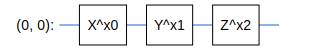

In [ ]:
SVGCircuit(one_qubit_unitary(cirq.GridQubit(0, 0), sympy.symbols('x0:3')))

顯示雙-量子位的單位電路：

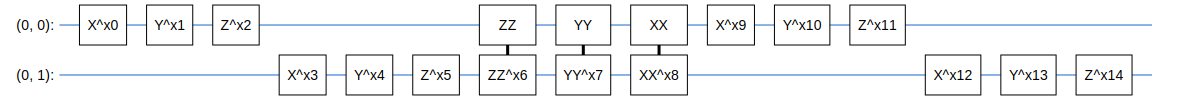

In [ ]:
SVGCircuit(two_qubit_unitary(cirq.GridQubit.rect(1, 2), sympy.symbols('x0:15')))

顯示雙-量子的池化電路：

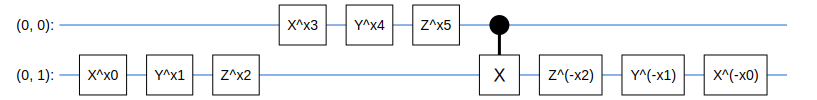

In [ ]:
SVGCircuit(two_qubit_pool(*cirq.GridQubit.rect(1, 2), sympy.symbols('x0:6')))

#### Quantum convolution

如 <a href="https://arxiv.org/abs/1810.03787" class="external">Cong and Lukin</a> 的論文所述，將一維量子卷積定義為：將雙-量子位參數化么正應用於每對相鄰量子，步長為1。

In [ ]:
def quantum_conv_circuit(bits, symbols):
    """Quantum Convolution Layer following the above diagram.
    Return a Cirq circuit with the cascade of `two_qubit_unitary` applied
    to all pairs of qubits in `bits` as in the diagram above.
    """
    circuit = cirq.Circuit()
    for first, second in zip(bits[0::2], bits[1::2]):
        circuit += two_qubit_unitary([first, second], symbols)
    for first, second in zip(bits[1::2], bits[2::2] + [bits[0]]):
        circuit += two_qubit_unitary([first, second], symbols)
    return circuit

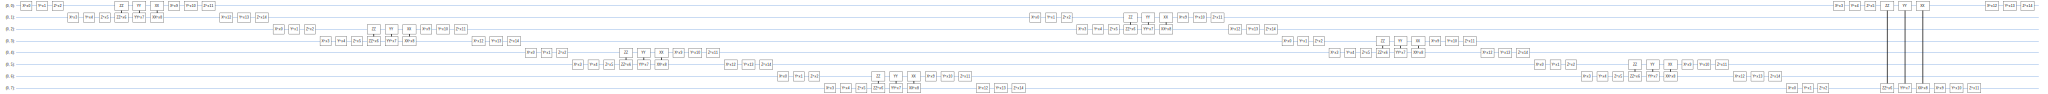

In [ ]:
SVGCircuit(
    quantum_conv_circuit(cirq.GridQubit.rect(1, 8), sympy.symbols('x0:15')))

#### Quantum pooling

量子池層使用上面定義的雙-量子池化，將 $N$ 個量子位池合併為 $\frac{N}{2}$ 個量子位元。

In [ ]:
def quantum_pool_circuit(source_bits, sink_bits, symbols):
    """A layer that specifies a quantum pooling operation.
    A Quantum pool tries to learn to pool the relevant information from two
    qubits onto 1.
    """
    circuit = cirq.Circuit()
    for source, sink in zip(source_bits, sink_bits):
        circuit += two_qubit_pool(source, sink, symbols)
    return circuit

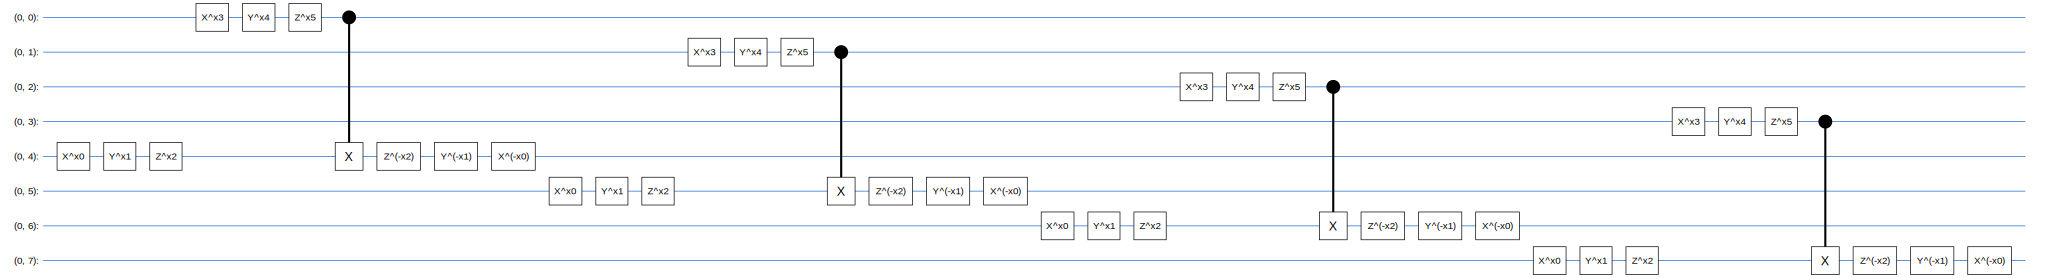

In [ ]:
test_bits = cirq.GridQubit.rect(1, 8)

SVGCircuit(
    quantum_pool_circuit(test_bits[:4], test_bits[4:], sympy.symbols('x0:6')))

### 建立混合模型

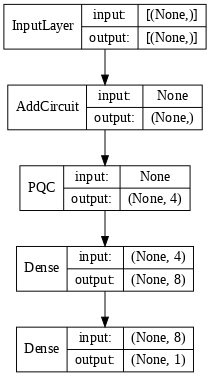

In [ ]:
# 1-local operators to read out
cluster_state_bits = cirq.GridQubit.rect(1, 8)
readouts = [cirq.Z(bit) for bit in cluster_state_bits[4:]]


def multi_readout_model_circuit(qubits):
    """Make a model circuit with less quantum pool and conv operations."""
    model_circuit = cirq.Circuit()
    symbols = sympy.symbols('qconv0:21')
    model_circuit += quantum_conv_circuit(qubits, symbols[0:15])
    model_circuit += quantum_pool_circuit(qubits[:4], qubits[4:],
    symbols[15:21])
    return model_circuit


def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: 1.0 if x >= 0 else -1.0, y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))
# input = tf.keras.layers.Dense(8)(input)

################################################################################
excitation_input_dual = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

cluster_state_dual = tfq.layers.AddCircuit()(
    excitation_input_dual, prepend=cluster_state_circuit(cluster_state_bits))

quantum_model_dual = tfq.layers.PQC(
    multi_readout_model_circuit(cluster_state_bits),
    readouts)(cluster_state_dual)

d1_dual = tf.keras.layers.Dense(8)(quantum_model_dual)

d2_dual = tf.keras.layers.Dense(1)(d1_dual)

hybrid_model = tf.keras.Model(inputs=[excitation_input_dual], outputs=[d2_dual])


# Display the model architecture
tf.keras.utils.plot_model( hybrid_model,
              show_shapes=True,
              show_layer_names=False,
              dpi=70)

### 訓練混合模型

In [ ]:
hybrid_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                     loss=tf.losses.mse,
                     metrics=['acc'])#custom_accuracy

hybrid_history = hybrid_model.fit(x_train_q,
                  y_train_q,
                  batch_size=200,
                  epochs=50,
                  verbose=1,
                  validation_data=(x_test_q , 
                          y_test_q))
                                

Epoch 1/50
13/13 [==============================] - 20s 2s/step - loss: 0.1233 - acc: 0.0169 - val_loss: 0.0563 - val_acc: 0.0240
Epoch 2/50
13/13 [==============================] - 19s 2s/step - loss: 0.0557 - acc: 0.0204 - val_loss: 0.0435 - val_acc: 0.0220
Epoch 3/50
13/13 [==============================] - 19s 1s/step - loss: 0.0416 - acc: 0.0180 - val_loss: 0.0262 - val_acc: 0.0220
Epoch 4/50
13/13 [==============================] - 20s 2s/step - loss: 0.0199 - acc: 0.0169 - val_loss: 0.0110 - val_acc: 0.0220
Epoch 5/50
13/13 [==============================] - 20s 2s/step - loss: 0.0109 - acc: 0.0175 - val_loss: 0.0073 - val_acc: 0.0210
Epoch 6/50
13/13 [==============================] - 20s 2s/step - loss: 0.0071 - acc: 0.0202 - val_loss: 0.0062 - val_acc: 0.0220
Epoch 7/50
13/13 [==============================] - 20s 2s/step - loss: 0.0065 - acc: 0.0156 - val_loss: 0.0062 - val_acc: 0.0220
Epoch 8/50
13/13 [==============================] - 20s 2s/step - loss: 0.0053 - acc: 0.01

### 建立普通模型

In [ ]:
input = tf.keras.Input(shape=(2), dtype=tf.dtypes.float32)
d1_dual = tf.keras.layers.Dense(16)(input)
d2_dual = tf.keras.layers.Dense(8)(d1_dual)
d3_dual = tf.keras.layers.Dense(1)(d2_dual)
normal_model = tf.keras.Model(inputs=[input], outputs=[d3_dual])

# Display the model architecture
tf.keras.utils.plot_model( normal_model,
              show_shapes=True,
              show_layer_names=False,
              dpi=70)

### 訓練普通模型

In [ ]:
normal_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                     loss=tf.losses.mse,
                     metrics=['acc'])#custom_accuracy

normal_history = normal_model.fit(x_train,
                  y_train,
                  batch_size=200,
                  epochs=50,
                  verbose=1,
                  validation_data=(x_test , 
                          y_test))

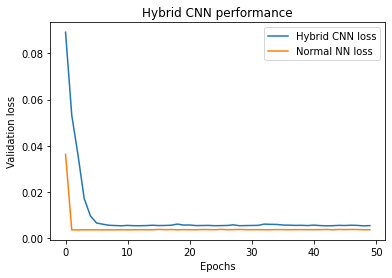

In [ ]:
plt.plot(hybrid_history.history['loss'], label='Hybrid CNN loss')
plt.plot(normal_history.history['loss'], label='Normal NN loss')
plt.title('Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation loss')
plt.show()

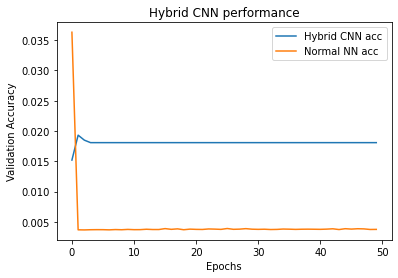

In [ ]:
plt.plot(hybrid_history.history['acc'], label='Hybrid CNN acc')
plt.plot(normal_history.history['loss'], label='Normal NN acc')
plt.title('Hybrid CNN performance')
plt.xlabel('Epochs')
plt.legend()
plt.ylabel('Validation Accuracy')
plt.show()